In [28]:
%load_ext autoreload
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
from kam11 import context, matchedField, thermister
from kam11.plotting import mfPlotting
from beamforming import curvedWaveFront, timeDomain

import matplotlib.pyplot as plt
import scipy.signal as sig

In [4]:
timeOfInterest_1Channel='2011 J184 03:51:00'
loadDuration_1Channel=dt.timedelta(0,59)

timeOfInterest='2011 J184 03:51:17'
loadDuration=dt.timedelta(0,5)

channelName_1Channel=2

thetaRange=(2,10)
numTheta=1000
beamformingStart=-5
beamformingEnd=2
numBeams=1000

In [5]:
tof = dt.datetime.strptime(timeOfInterest_1Channel,\
                           '%Y J%j %H:%M:%S')
ssp=thermister.getSoundSpeed(tof)
rd=context.VLA1().phoneDepths()

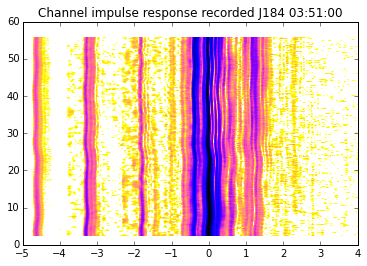

In [6]:
cirEstimate=matchedField.LFM_MatchedFilter(tof,\
        loadChannels=[channelName_1Channel],\
        loadDuration=loadDuration_1Channel)

mf_1Channel=cirEstimate.matchedFilter()
#Single channel plots
ax=mfPlotting.plotSingleChannel(mf_1Channel,channelName_1Channel,\
                                tStart=-5,tEnd=4)

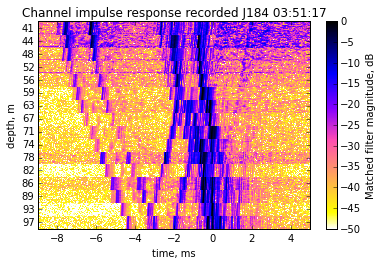

In [31]:
tof = dt.datetime.strptime(timeOfInterest,\
                           '%Y J%j %H:%M:%S')
cirEstimate=matchedField.LFM_MatchedFilter(tof,
                loadDuration=loadDuration)
mf=cirEstimate.matchedFilter()
#Multichannel plots
ax=mfPlotting.plotMultipleChannel(mf, mf['channelNames'],\
            vmin=-50, tStart=-9, tEnd=5, norm='channel')

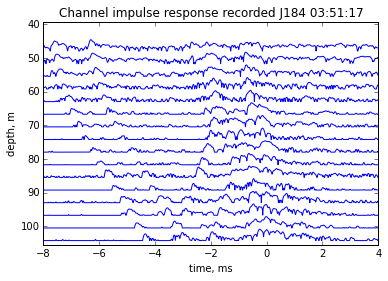

In [30]:
# Single time plot
%autoreload
ax=mfPlotting.plotSingleTime(mf, mf['channelNames'], 0, tStart=-8,\
            tEnd=4, vmin=-40, norm='channel')

In [10]:
#Beamform on second match field result
fastTime=mf[mf['channelNames'][0]].index
def getSecondSnap():
    for m in mf['channelNames']:
        yield(mf[m].iloc[:,1])
lookData=pd.DataFrame(list(getSecondSnap()),\
        index=mf['channelNames'], columns=fastTime).T

thetaTest=np.r_[thetaRange[0]:thetaRange[1]:1j*numTheta]
testDelay=curvedWaveFront.getDelays(thetaTest, ssp, rd, rd[1])

centerTime=np.r_[beamformingStart:beamformingEnd:1j*numBeams]
centerTime/=1e3

beams=timeDomain.timeBeamformer(lookData, centerTime, testDelay)

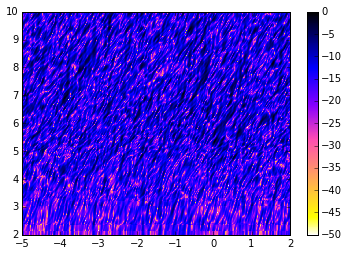

In [11]:
lookDB=20*np.log10(np.abs(np.array(beams))+np.spacing(1))
lookDB-=np.max(lookDB)
X,Y=np.meshgrid(1e3*centerTime,thetaTest)
fig,ax=plt.subplots()
pc=ax.pcolormesh(X,Y,lookDB.T,vmin=-50,vmax=0,cmap=plt.cm.gnuplot2_r)
cb=fig.colorbar(pc)
# _=cb.set_ticks([-40,-30-20,-10,0])
# _=ax.set_xlim(beamformingStart,beamformingEnd)